In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize']=20,8
plt.style.use('ggplot')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Statsmodel imports
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
# adfuller test

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [3]:
df=pd.read_csv('btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv')

In [4]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325292180,4.247,4.247,4.247,4.247,0.4,1.6988,4.247
1,1325292240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325292300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325292360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325292420,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean the dataset

In [5]:
# unix-time to Datetime
df.Timestamp=pd.to_datetime(df.Timestamp, unit='s')

## Resampling the Data

In [6]:
# Daily Frequency
df.index=df.Timestamp
df=df.resample('D').mean()
               
# Monthly Frequency
df_month=df.resample('M').mean()

# Annual Frequency
df_year=df.resample('A-DEC').mean()

# Quarterly Frequency
df_Q=df.resample('Q-DEC').mean()

## Plotting data at diffrenct frequencies

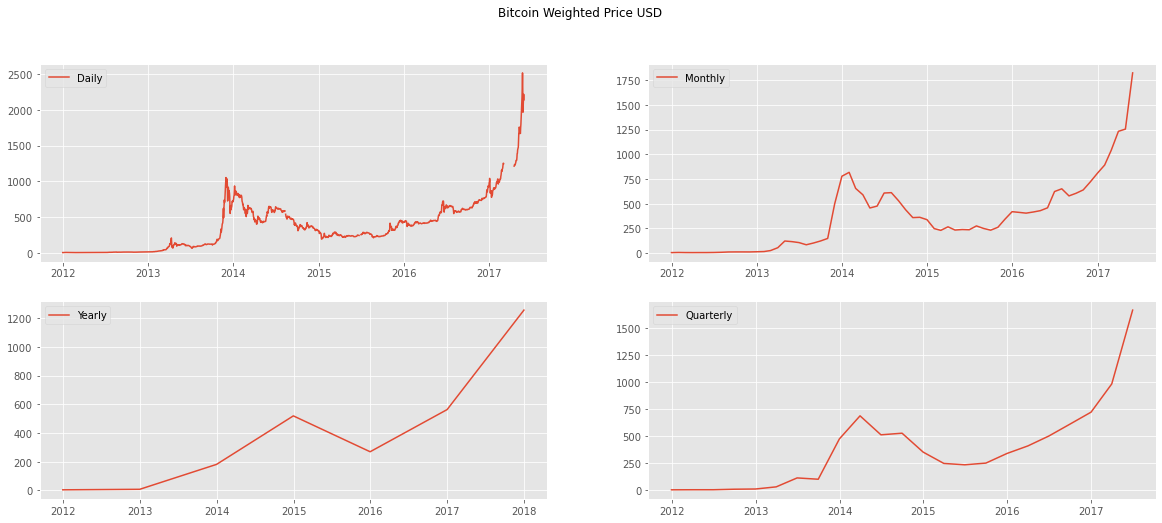

In [7]:
plt.suptitle('Bitcoin Weighted Price USD')

plt.subplot(2,2,1)
plt.plot(df.Weighted_Price, label='Daily')
plt.legend()

plt.subplot(2,2,2)
plt.plot(df_month.Weighted_Price, label='Monthly')
plt.legend()

plt.subplot(2,2,3)
plt.plot(df_year.Weighted_Price, label='Yearly')
plt.legend()

plt.subplot(2,2,4)
plt.plot(df_Q.Weighted_Price, label='Quarterly')
plt.legend();

# Stationarity Check

In [8]:
adf_test(df_month['Weighted_Price'])

Augmented Dickey-Fuller Test: 
ADF test statistic       1.568601
p-value                  0.997760
# lags used              1.000000
# observations          64.000000
critical value (1%)     -3.536928
critical value (5%)     -2.907887
critical value (10%)    -2.591493
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


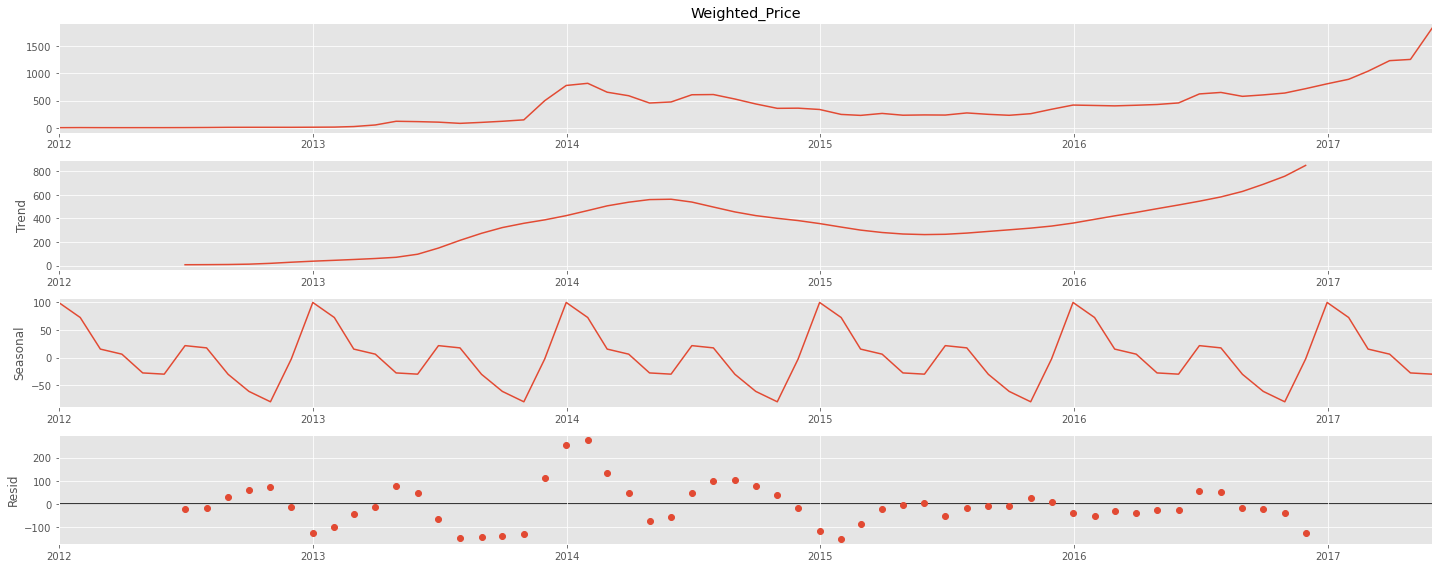

In [9]:
result=seasonal_decompose(df_month['Weighted_Price'])
result.plot();

In [10]:
# Box-Cox Transformations
from scipy import stats
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)

In [11]:
df_month.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box
Timestamp,,,,,,,,
2011-12-31,4.439149,4.447614,4.437737,4.444623,10.797146,47.337181,4.444100,1.957417
2012-01-31,5.930796,5.935654,5.926930,5.931866,6.916276,41.434936,5.931953,2.469007
2012-02-29,4.904388,4.907574,4.901974,4.905173,11.706357,55.533516,4.904974,2.126451
2012-03-31,4.568632,4.571024,4.565848,4.568261,25.051046,114.375210,4.568499,2.004125
2012-04-30,4.848076,4.849581,4.846350,4.847884,36.632500,176.767130,4.847963,2.106117


### Seasonal Differentiation

In [12]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
adf_test(df_month['prices_box_diff'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.416113
p-value                  0.137240
# lags used              7.000000
# observations          46.000000
critical value (1%)     -3.581258
critical value (5%)     -2.926785
critical value (10%)    -2.601541
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Regular Differentiation

In [13]:
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
adf_test(df_month['prices_box_diff2'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.307685
p-value                  0.014538
# lags used             11.000000
# observations          41.000000
critical value (1%)     -3.600983
critical value (5%)     -2.935135
critical value (10%)    -2.605963
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [14]:
monthly_diff=df_month['Weighted_Price']-df_month['Weighted_Price'].shift(1)

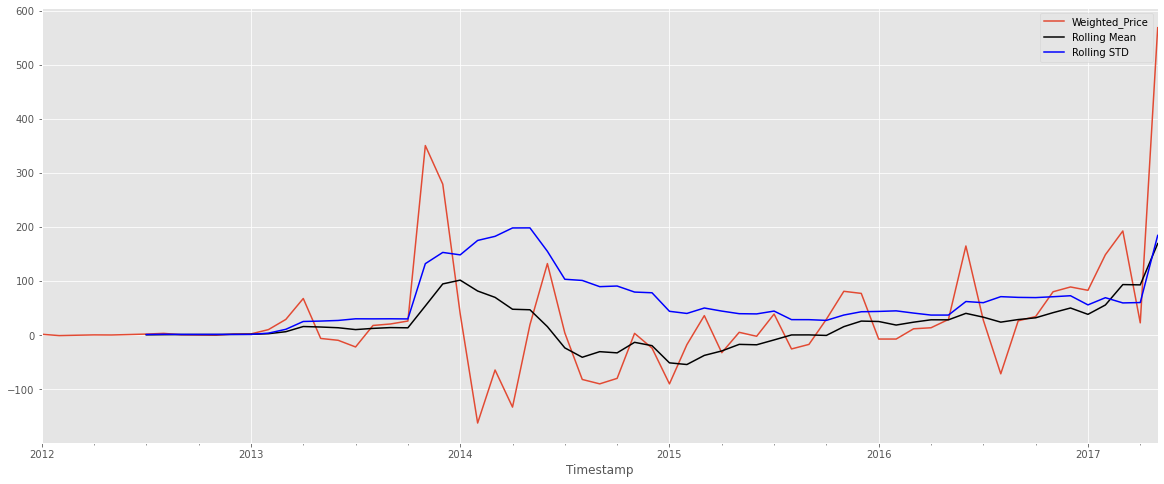

In [15]:
monthly_diff[1:].plot(legend=True)
monthly_diff[1:].rolling(7).mean().plot(label='Rolling Mean',c='black',legend=True)
monthly_diff[1:].rolling(7).std().plot(label='Rolling STD',c='b',legend=True);

In [16]:
adf_test(monthly_diff[1:])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.331038
p-value                  0.013547
# lags used              0.000000
# observations          64.000000
critical value (1%)     -3.536928
critical value (5%)     -2.907887
critical value (10%)    -2.591493
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# Modelling SARIMA

In [17]:
from sklearn.model_selection import train_test_split as split

train, test=split(df_month['Weighted_Price'], train_size=0.7, shuffle=False)

In [18]:
train.head()

Timestamp
2011-12-31    4.444100
2012-01-31    5.931953
2012-02-29    4.904974
2012-03-31    4.568499
2012-04-30    4.847963
Freq: M, Name: Weighted_Price, dtype: float64

In [19]:
test.head()

Timestamp
2015-10-31    260.654988
2015-11-30    341.569495
2015-12-31    418.620094
2016-01-31    411.229366
2016-02-29    403.823040
Freq: M, Name: Weighted_Price, dtype: float64

In [20]:
print('Train',len(train))
print('Test',len(test))

Train 46
Test 20


In [21]:
import itertools
p=q=P=Q=range(0,3)
d=D=1
parameter_list=list(itertools.product(p,q,P,Q))

In [22]:
parameter_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0, 2),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 0, 1, 2),
 (1, 0, 2, 0),
 (1, 0, 2, 1),
 (1, 0, 2, 2),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 0, 2),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 1, 1, 2),
 (1, 1, 2, 0),
 (1, 1, 2, 1),
 (1, 1, 2, 2),
 (1, 2, 0, 0),
 (1, 2, 0, 1),
 (1, 2, 0, 2),
 (1, 2, 1, 0),
 (1, 2, 1, 1),
 (1, 2, 1, 2),
 (1, 2, 2, 0),
 (1, 2, 2, 1),
 (1, 2, 2, 2),
 (2, 0, 0, 0),
 (2, 0, 0, 1),
 (2, 0, 0, 2),
 (2, 0, 1, 0),
 (2, 0, 1, 1),
 (2, 0, 1, 2),
 (2, 0, 2, 0),
 (2, 0, 2, 1),
 (2, 0, 2, 2),
 (2, 1, 0, 0),
 (2, 1, 0, 1),
 (2, 1, 0, 2),
 (2, 1, 1,

In [48]:
results = []
best_aic = float("inf")

for param in parameter_list:
    try:
        model = sm.tsa.statespace.SARIMAX(df_month.Weighted_Price,
                                          order=(param[0],d,param[1]),
                                          seasonal_order=(param[2],D,param[3],12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit(disp = -1)

    except:
        print('wrong parameters:', param)
        continue
    
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

/Users/harkiratchahal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/harkiratchahal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/harkiratchahal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/harkiratchahal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/harkiratc

In [49]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
best_model.summary()

      parameters         aic
53  (1, 2, 2, 2)  321.051311
47  (1, 2, 0, 2)  321.652704
74  (2, 2, 0, 2)  321.818130
80  (2, 2, 2, 2)  322.912749
50  (1, 2, 1, 2)  323.084978


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Weighted_Price   No. Observations:                   66
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -152.526
Date:                            Fri, 23 Dec 2022   AIC                            321.051
Time:                                    23:30:55   BIC                            331.116
Sample:                                12-31-2011   HQIC                           323.950
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2637      0.068     18.690      0.000       1.131       1.396
ma.L1         -1.3835      0.322     -4.300      0.000      -2.014      -0.753
ma.L2          0.3835      0.347      1.106      0.269      -0.296       1.063
ar.S.L12      -0.5940      0.254     -2.335      0.020      -1.093      -0.095
ar.S.L24      -0.1575      0.255     -0.618      0.536      -0.657       0.342
ma.S.L12       0.0721      0.733      0.098      0.922      -1.365       1.509
ma.S.L24       0.1045      1.199      0.087      0.931      -2.245       2.454
sigma2      6439.2326   6.75e-05   9.54e+07      0.000    6439.232    6439.233
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.75   Prob(JB):                         0.11
Heteroskedasticity (H):               6.58   Skew:                             0.54
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.46e+24. Standard errors may be unstable.
"""

In [25]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [26]:
df_month.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
Timestamp,,,,,,,,,,
2011-12-31,4.439149,4.447614,4.437737,4.444623,10.797146,47.337181,4.444100,1.957417,NaN,NaN
2012-01-31,5.930796,5.935654,5.926930,5.931866,6.916276,41.434936,5.931953,2.469007,NaN,NaN
2012-02-29,4.904388,4.907574,4.901974,4.905173,11.706357,55.533516,4.904974,2.126451,NaN,NaN
2012-03-31,4.568632,4.571024,4.565848,4.568261,25.051046,114.375210,4.568499,2.004125,NaN,NaN
2012-04-30,4.848076,4.849581,4.846350,4.847884,36.632500,176.767130,4.847963,2.106117,NaN,NaN


In [27]:
len(df_month)

66

In [58]:
predictions=best_model.predict(start=0, end=len(df_month)-1)

In [59]:
predictions

Timestamp
2011-12-31       0.000000
2012-01-31       6.316103
2012-02-29       7.971338
2012-03-31       4.872798
2012-04-30       4.266393
                 ...     
2017-01-31     893.384282
2017-02-28     993.217020
2017-03-31    1213.370105
2017-04-30    1422.498961
2017-05-31    1566.308584
Freq: M, Name: predicted_mean, Length: 66, dtype: float64

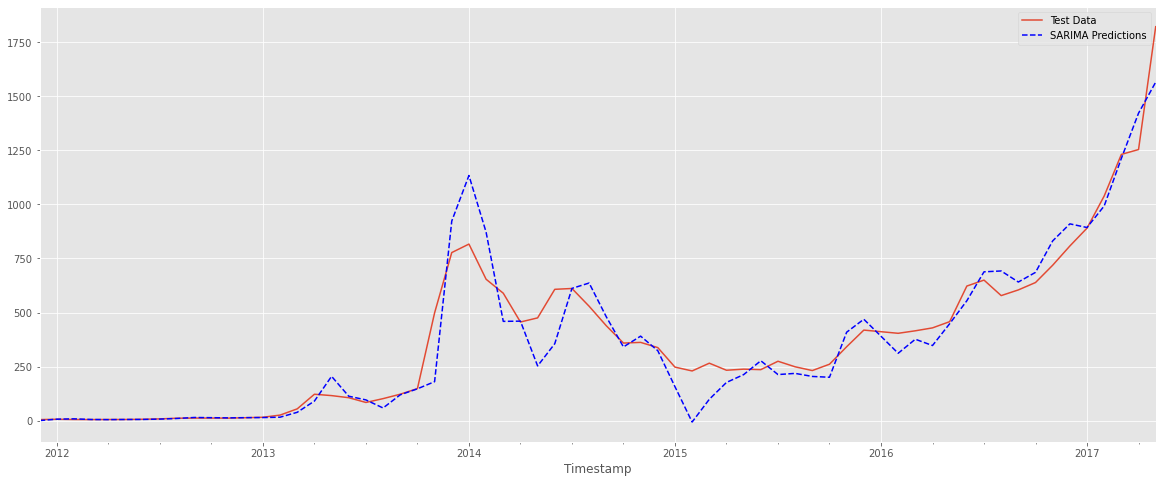

In [60]:
df_month['Weighted_Price'].plot(legend=True, label='Test Data')
predictions.plot(legend=True, label='SARIMA Predictions', linestyle='--', color='b');

# Holts Winter Method

In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [68]:
df_month['TES_mul_12']=ExponentialSmoothing(df_month['Weighted_Price'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues

<AxesSubplot:xlabel='Timestamp'>

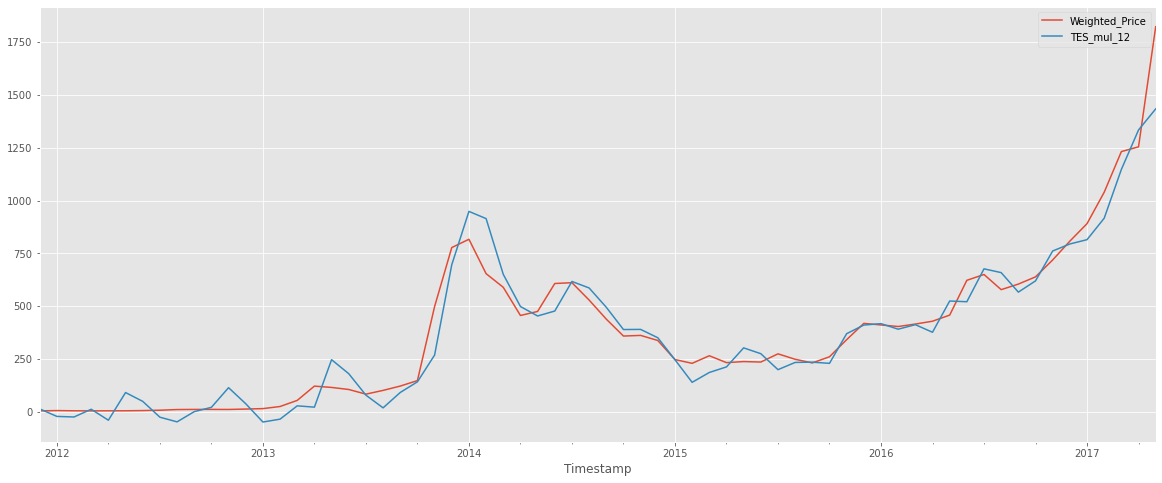

In [69]:
df_month[['Weighted_Price','TES_mul_12']].plot()

### Forecasting using Holts Winters

In [70]:
fitted_model=ExponentialSmoothing(df_month['Weighted_Price'], trend='add', seasonal='add', seasonal_periods=12).fit()

In [77]:
fcast=fitted_model.forecast(12)

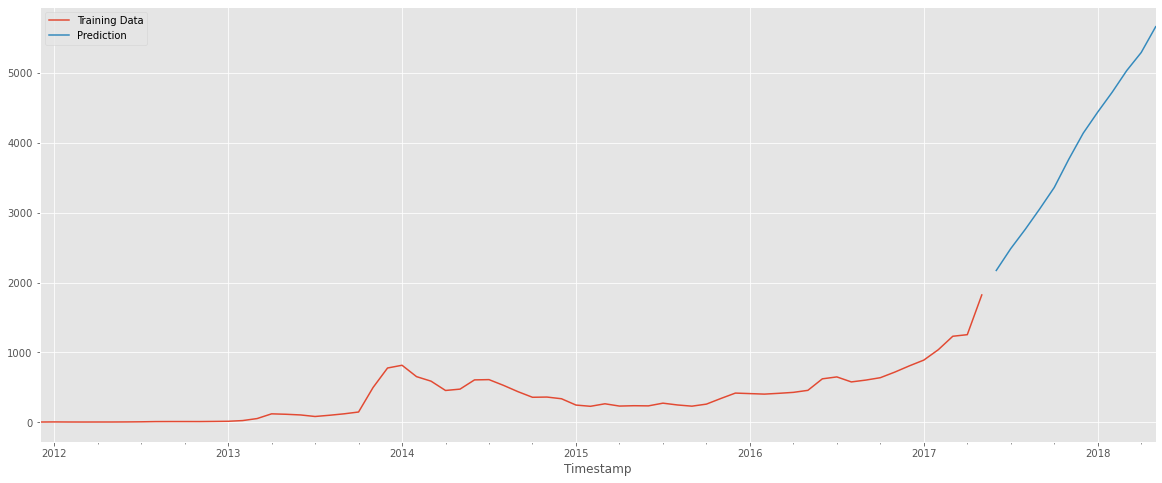

In [78]:
df_month['Weighted_Price'].plot(label='Training Data', legend=True)
fcast.plot(label='Prediction', legend=True);